## **3. A Markov jump (or switching) stochastic LQR**

In [2]:
import torch
import torch.nn as nn
import numpy as np
from scipy.linalg import solve_continuous_are, solve_lyapunov
import matplotlib.pyplot as plt
import torch.optim as optim

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

**(a)** Design a PINN algorithm to solve the HJB systems.

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float32

In [5]:
# Common parameters from the homework
rho = 0.1
A = torch.tensor([[0., 1.], [-2., -3.]], dtype=DTYPE, device=DEVICE)
B = torch.tensor([[0.], [1.]], dtype=DTYPE, device=DEVICE)
G = torch.tensor([[0.1, 0.], [0., 0.1]], dtype=DTYPE, device=DEVICE)
Q = torch.tensor([[1., 0.], [0., 1.]], dtype=DTYPE, device=DEVICE)
R = torch.tensor([[1.]], dtype=DTYPE, device=DEVICE)
GG_T = G @ G.T

# PINN training parameters
N_train = 2000
learning_rate = 5e-3
epochs = 5000

In [6]:
# Helper function to compute the Hessian for a batch of inputs
def hessian(output, inputs):
    """Computes the Hessian of a scalar-valued function for a batch of inputs."""
    # output shape: (N, 1), inputs shape: (N, 2)
    grad_output = torch.autograd.grad(outputs=output.sum(), inputs=inputs, create_graph=True)[0]
    
    hess = []
    for i in range(inputs.shape[1]):
        # grad of each component of the grad_output
        grad_of_grad_i = torch.autograd.grad(outputs=grad_output[:, i].sum(), inputs=inputs, create_graph=True)[0]
        hess.append(grad_of_grad_i)
    
    return torch.stack(hess, dim=2) # Result shape: (N, 2, 2)

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [12]:
# Analytical Solutions and PINN Implementation
P1_analytical = torch.tensor([[1.1527, 0.2149], [0.2149, 0.2295]], dtype=DTYPE, device=DEVICE)
P2_analytical = torch.tensor([[1.2002, 0.2643], [0.2643, 0.2807]], dtype=DTYPE, device=DEVICE)
print("Analytical P1 matrix:\n", P1_analytical.cpu().numpy())
print("Analytical P2 matrix:\n", P2_analytical.cpu().numpy())

def V_analytical_3(x, P):
    return torch.einsum('bi,ij,bj->b', x, P, x)

A2 = torch.tensor([[0., 1.], [-1.5, -2.5]], dtype=DTYPE, device=DEVICE)
lambda12, lambda21 = 0.5, 0.3

V1_model_3 = ValueNetwork().to(DEVICE)
V2_model_3 = ValueNetwork().to(DEVICE)
params = list(V1_model_3.parameters()) + list(V2_model_3.parameters())
optimizer_3 = torch.optim.Adam(params, lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, patience=500, factor=0.5)

# Training loop
for epoch in range(epochs):
    domain_points = torch.rand((N_train, 2), device=DEVICE) * 4 - 2
    domain_points.requires_grad = True
    
    optimizer_3.zero_grad()
    
    V1, V2 = V1_model_3(domain_points), V2_model_3(domain_points)
    grad_V1 = torch.autograd.grad(V1.sum(), domain_points, create_graph=True)[0]
    hess_V1 = hessian(V1, domain_points)
    grad_V2 = torch.autograd.grad(V2.sum(), domain_points, create_graph=True)[0]
    hess_V2 = hessian(V2, domain_points)

    # Hamiltonians
    ham1 = (torch.einsum('bi,ij,bj->b', domain_points, Q, domain_points)
            - 0.25 * torch.einsum('bi,ij,bj->b', grad_V1, B @ torch.inverse(R) @ B.T, grad_V1)
            + torch.einsum('bi,bi->b', grad_V1, domain_points @ A.T)
            + 0.5 * torch.einsum('bii->b', GG_T @ hess_V1))
    ham2 = (torch.einsum('bi,ij,bj->b', domain_points, Q, domain_points)
            - 0.25 * torch.einsum('bi,ij,bj->b', grad_V2, B @ torch.inverse(R) @ B.T, grad_V2)
            + torch.einsum('bi,bi->b', grad_V2, domain_points @ A2.T)
            + 0.5 * torch.einsum('bii->b', GG_T @ hess_V2))
    
    # HJB residuals
    f1 = rho * V1.squeeze() - (ham1 + lambda12 * (V2.squeeze() - V1.squeeze()))
    f2 = rho * V2.squeeze() - (ham2 + lambda21 * (V1.squeeze() - V2.squeeze()))
    loss = torch.mean(f1**2) + torch.mean(f2**2)
    
    loss.backward()
    optimizer_3.step()
    scheduler.step(loss)

    if epoch % 500 == 0:
        print(f"Problem 3 - Epoch {epoch}: Loss = {loss.item()}")

Analytical P1 matrix:
 [[1.1527 0.2149]
 [0.2149 0.2295]]
Analytical P2 matrix:
 [[1.2002 0.2643]
 [0.2643 0.2807]]
Problem 3 - Epoch 0: Loss = 19.28597640991211
Problem 3 - Epoch 500: Loss = 0.02344566583633423
Problem 3 - Epoch 1000: Loss = 0.006729764398187399
Problem 3 - Epoch 1500: Loss = 0.003459033090621233
Problem 3 - Epoch 2000: Loss = 0.0008236168650910258
Problem 3 - Epoch 2500: Loss = 0.0007361177704297006
Problem 3 - Epoch 3000: Loss = 0.0007562467362731695
Problem 3 - Epoch 3500: Loss = 0.0180111825466156
Problem 3 - Epoch 4000: Loss = 0.002064173575490713
Problem 3 - Epoch 4500: Loss = 0.002267175354063511


**(b)** For the given parameters, use your PINN algorithm to solve the problem. Compare your result with the one obtained by analytical solutions.


Problem 3 - Relative L2 Error for V1: 1.7217e-02
Problem 3 - Relative L2 Error for V2: 2.7033e-02



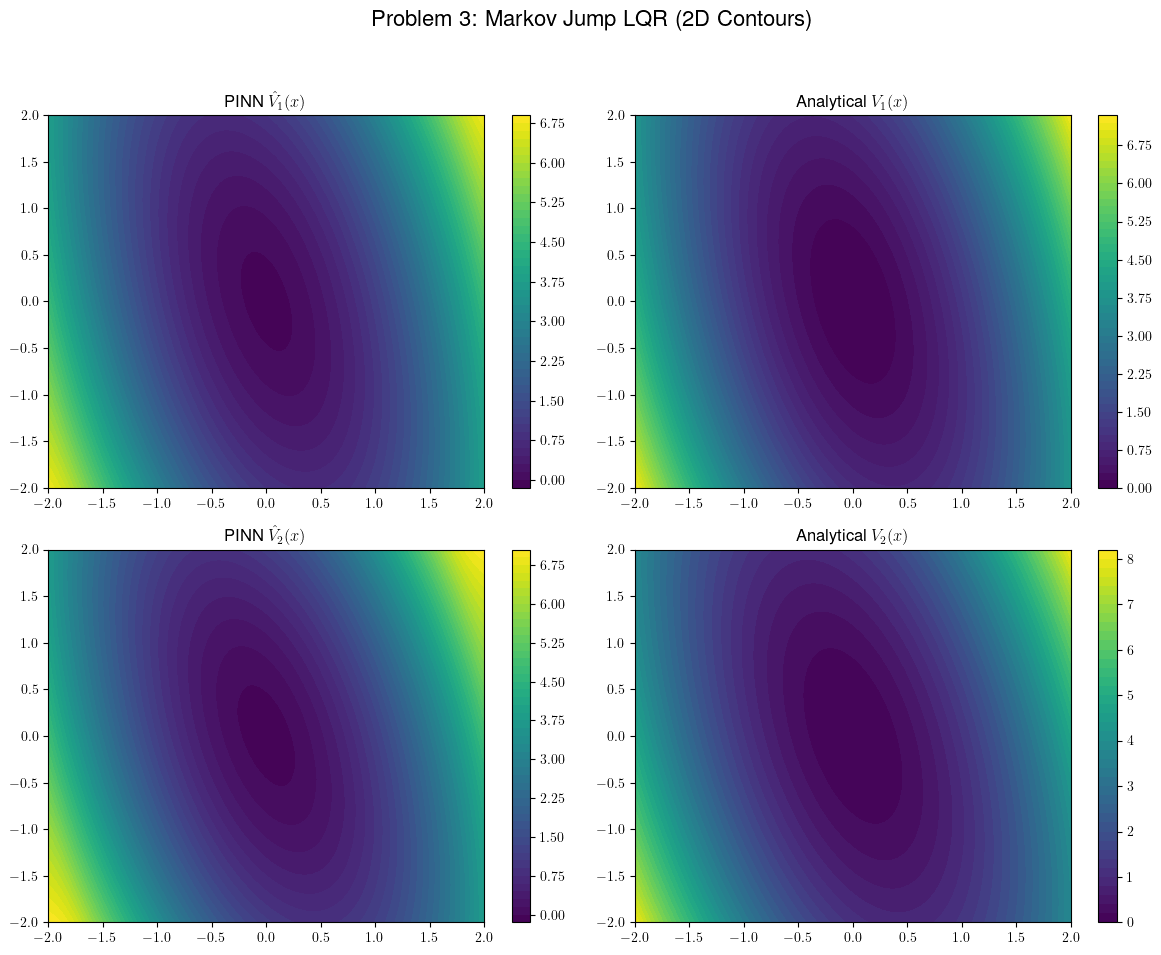

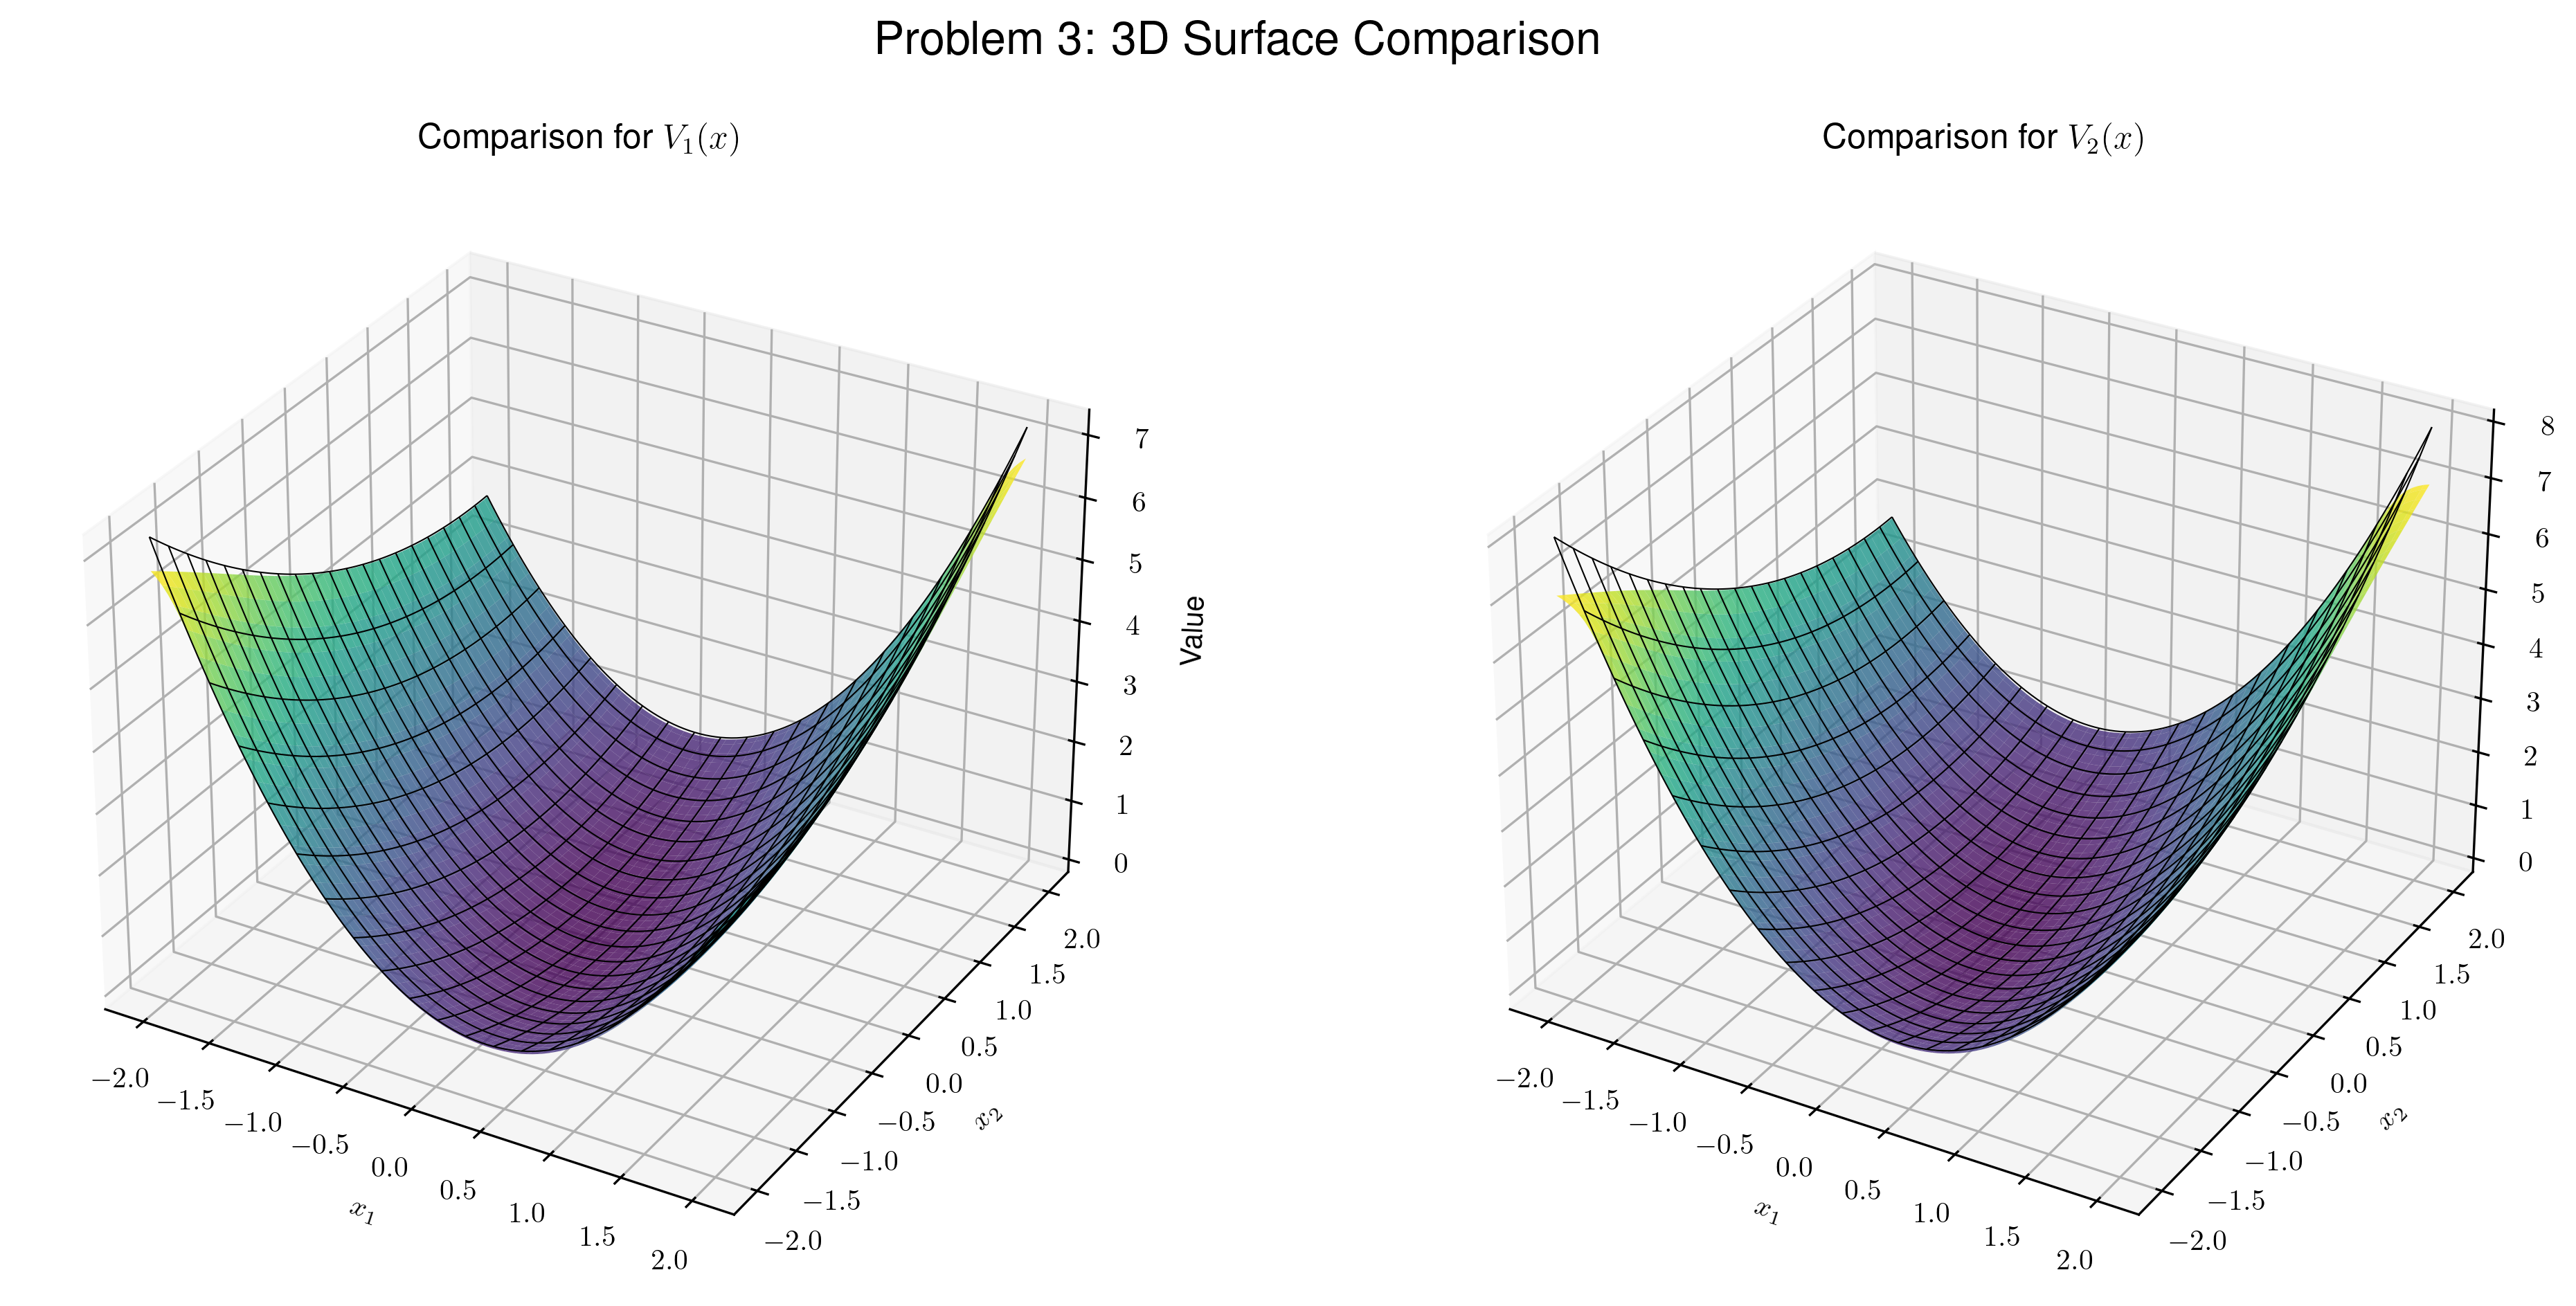

In [13]:
# Comparison
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
x_grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=DTYPE, device=DEVICE)

V1_pinn = V1_model_3(x_grid).detach().cpu().numpy().squeeze()
V2_pinn = V2_model_3(x_grid).detach().cpu().numpy().squeeze()
V1_true = V_analytical_3(x_grid, P1_analytical).detach().cpu().numpy()
V2_true = V_analytical_3(x_grid, P2_analytical).detach().cpu().numpy()

rel_error_V1 = np.linalg.norm(V1_pinn - V1_true) / np.linalg.norm(V1_true)
rel_error_V2 = np.linalg.norm(V2_pinn - V2_true) / np.linalg.norm(V2_true)
print(f"\nProblem 3 - Relative L2 Error for V1: {rel_error_V1:.4e}")
print(f"Problem 3 - Relative L2 Error for V2: {rel_error_V2:.4e}\n")

# Plot 1: Original 2D Contour Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
im1 = axes[0, 0].contourf(xx, yy, V1_pinn.reshape(100, 100), 50, cmap='viridis')
axes[0, 0].set_title(r'PINN $\hat{V}_1(x)$'); fig.colorbar(im1, ax=axes[0, 0])
im2 = axes[0, 1].contourf(xx, yy, V1_true.reshape(100, 100), 50, cmap='viridis')
axes[0, 1].set_title(r'Analytical $V_1(x)$'); fig.colorbar(im2, ax=axes[0, 1])
im3 = axes[1, 0].contourf(xx, yy, V2_pinn.reshape(100, 100), 50, cmap='viridis')
axes[1, 0].set_title(r'PINN $\hat{V}_2(x)$'); fig.colorbar(im3, ax=axes[1, 0])
im4 = axes[1, 1].contourf(xx, yy, V2_true.reshape(100, 100), 50, cmap='viridis')
axes[1, 1].set_title(r'Analytical $V_2(x)$'); fig.colorbar(im4, ax=axes[1, 1])
plt.suptitle("Problem 3: Markov Jump LQR (2D Contours)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot 2: New 3D Surface Plots for Comparison
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create a new figure for the 3D plots
fig_3d = plt.figure(figsize=(16, 7), dpi=300)
fig_3d.suptitle("Problem 3: 3D Surface Comparison", fontsize=16)

# Subplot for V1
ax1 = fig_3d.add_subplot(1, 2, 1, projection='3d')
# Plot the analytical solution as a wireframe
ax1.plot_wireframe(xx, yy, V1_true.reshape(100, 100), color='black', rstride=5, cstride=5, linewidth=0.5, label=r'Analytical $V_1(x)$')
# Plot the PINN solution as a surface
surf1 = ax1.plot_surface(xx, yy, V1_pinn.reshape(100, 100), cmap=cm.viridis, alpha=0.8, label=r'PINN $\hat{V}_1(x)$')
ax1.set_title(r'Comparison for $V_1(x)$')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax1.set_zlabel('Value')

# Subplot for V2
ax2 = fig_3d.add_subplot(1, 2, 2, projection='3d')
# Plot the analytical solution as a wireframe
ax2.plot_wireframe(xx, yy, V2_true.reshape(100, 100), color='black', rstride=5, cstride=5, linewidth=0.5, label=r'Analytical $V_2(x)$')
# Plot the PINN solution as a surface
surf2 = ax2.plot_surface(xx, yy, V2_pinn.reshape(100, 100), cmap=cm.viridis, alpha=0.8, label=r'PINN $\hat{V}_2(x)$')
ax2.set_title(r'Comparison for $V_2(x)$')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.set_zlabel('Value')

plt.show()